In [804]:
import pinocchio
import numpy as np
import time 
import pymanopt 
from pymanopt import manifolds, optimizers, tools, core
from pymanopt.core.problem  import Problem
from pymanopt.tools.diagnostics import *
from utils import *
import networkx as nx
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

import tqdm

from scipy.sparse import csr_array

LOWER = "lower_limit"
UPPER = "upper_limit"
BOUNDED = "bounded"
BELOW = "below"
ABOVE = "above"
TYPE = "type"
OBSTACLE = "obstacle"
ROBOT = "robot"
END_EFFECTOR = "end_effector"
RADIUS = "radius"
DIST = "weight"
POS = "pos"
BASE = "base"
ROOT = None
ANCHOR = "anchor"
BASE_GRAPH = "base_graph"
UNDEFINED = None


deg2rad = np.pi/180.
rad2deg = 180./np.pi

scale = 1

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [805]:
def forwardKinematics(model,data,q,scale=1):
    pinocchio.forwardKinematics(model,data,q)
    for idx, oMi in enumerate(data.oMi):
        oMi.translation = scale*oMi.translation


def compute_rotation_axis_from_model(model,data):
    axis = []
    q0 = pinocchio.neutral(model)
    for i in range(q0.shape[0]):
        q = np.zeros((q0.shape[0]))
        q[i] = np.pi/4
        pinocchio.forwardKinematics(model,data,q)
        R_ref = data.oMi[i+1].rotation
        
        if np.abs(np.sum(R_ref@np.array([1.,0,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([1,0,0.])) + 1) < 10**-4:
            axis.append('x')
        elif np.abs(np.sum(R_ref@np.array([0,1,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,1,0.])) + 1) < 10**-4:
            axis.append('y')
        elif np.abs(np.sum(R_ref@np.array([0,0,1.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,0,1.])) + 1) < 10**-4:
            axis.append('z')
        else:
            print(2)
    return axis

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))


In [806]:
def create_base_graph(model,data,axis_length):

    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))

    q_init = pinocchio.neutral(model)
    
    pinocchio.forwardKinematics(model,data,q_init)
    
    robot_name = model.names[1]
    ROOT = robot_name

    base = nx.empty_graph()

    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            cur_pos, aux_cur_pos = (
                oMi.translation*scale,
                pinocchio.SE3.act(pinocchio.SE3(oMi.rotation,oMi.translation*scale),trans_z[idx-1]).translation,
            )

            #print(name,trans_z[idx-1].translation)
            
            dist = np.linalg.norm(cur_pos - aux_cur_pos)

            # Add nodes for joint and edge between them
            base.add_nodes_from(
                [(cur, {POS: cur_pos}), (aux_cur, {POS: aux_cur_pos})]
            )
            base.add_edge(
                cur, aux_cur, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False}
            )
            
            # If there exists a preceeding joint, connect it to new
            if idx != 0:
                pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')
                for u in [pred, aux_pred]:
                    for v in [cur, aux_cur]:
                        dist = np.linalg.norm(
                            base.nodes[u][POS] - base.nodes[v][POS]
                        )
                        base.add_edge(
                            u,
                            v,
                            **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False},
                        )
        elif idx == 1:
            #print(name,oMi.translation)
            base = nx.DiGraph(
                [
                    (robot_name, "x"),
                    (robot_name, "y"),
                    (robot_name, robot_name+'_tilde'),
                    ("x", "y"),
                    ("y", robot_name+'_tilde'),
                    (robot_name+'_tilde' ,"x"),
                ]
            )
            base.add_nodes_from(
                [
                    ("x", {POS: np.array([axis_length, 0, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    ("y", {POS: np.array([0, -axis_length, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    (robot_name, {POS: oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                    (robot_name+'_tilde', {POS: trans_z[idx-1].translation + oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                ]
            )
            for u, v in base.edges():
                base[u][v][DIST] = np.linalg.norm(base.nodes[u][POS] - base.nodes[v][POS])
                base[u][v][LOWER] = base[u][v][DIST]
                base[u][v][UPPER] = base[u][v][DIST]
                base[u][v][ANCHOR] = True
                base[u][v][BOUNDED] = []

    # Set node type to robot
    nx.set_node_attributes(base, [ROBOT], TYPE)
    base.nodes[ROOT][TYPE] = [ROBOT, BASE]
    base.nodes[ROOT + '_tilde'][TYPE] = [ROBOT, BASE]


    return base


In [807]:

def norm(x):
    return x/max(np.linalg.norm(x),10**-9)

def goal_graph(model, data, G2, axis_length, position, direction = None, anchor = True):
    
    end_effector = [model.names[-1]]
    if direction is not None:
        end_effector.append(model.names[-1]+'_tilde')

    list_nodes_base = ['x','y',model.names[1],model.names[1]+'_tilde']

    for i, cur_end_effector in enumerate(end_effector):
        pos_end = position

        if direction is not None and i == 1:
            pos_end = pos_end + direction*axis_length
        
        G2.nodes[cur_end_effector][POS] = pos_end

        for cur_base in list_nodes_base:
            
            if not((i == 1) and (len(end_effector)==1)):
                dist = np.linalg.norm(pos_end-G2.nodes[cur_base][POS])

                G2.add_edge(
                            cur_base, cur_end_effector, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    if direction is not None:
        dist = axis_length
        G2.add_edge(
                            model.names[-1],model.names[-1]+'_tilde', **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    
    if True:#anchor:

        list_edges_anchor = []
        list_other_edges = []
        new_edge_order  = []
        A_anchor = []

        for key ,anch_ in nx.get_edge_attributes(G2,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G2.nodes[key[1]][POS]- G2.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)
        new_edge_order = list_edges_anchor.copy() #.extend(list_other_edges)

        for e in list_other_edges:
            new_edge_order.append(e)

        A_anchor = np.array(A_anchor).transpose()
        
    else:

        list_edges_anchor = []
        list_other_edges = [e for e in G2.edges()]

        new_edge_order = list_other_edges
        A_anchor = []

    n = len(list_other_edges)
    n_anchor = len(list_edges_anchor)

    weight = nx.get_edge_attributes(G2, DIST)
    D = np.diag([weight[i] for i in new_edge_order])

    C = incidence_matrix_(G2,oriented=True, edgelist=new_edge_order).toarray()
    C = np.array(C)

    Y_init = np.zeros((3,n))

    for i, e in enumerate(list_other_edges):
        i = i 
        p1 = G2.nodes[e[0]][POS]
        p2 = G2.nodes[e[1]][POS]
        Y_init[:,i] = (p2-p1)/max(np.linalg.norm(p2-p1),10**-9)

    Y_init = [A_anchor,Y_init]
    return G2, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init

In [849]:
alpha_elu = 10**-5
elu = lambda x: alpha_elu*(np.exp(x/alpha_elu*(x<0))-1)*(x<0) +  x*(x>=0)
d_elu = lambda x: np.exp(x/alpha_elu*(x<0))*(x<0) + (x>=0)
dd_elu = lambda x: 1/alpha_elu*np.exp(x/alpha_elu*(x<0))*(x<0)

def simple_IK(d ,C , C_joints_limit ,D ,D_joints ,n_below, n_above, Anchor_ ,M ,max_iter,ind=None ,W=None ,Y_init=None ,
                use_rand=False, min_grad_norm = 10**-10,verbosity = 2,lambda_cons=1):
    if  W is None:
        W = np.eye(D.shape[0])
    if len(Anchor_)>0:
        #print('ANCHOR')
        n_anchor = Anchor_.shape[1]
        Anchor = np.zeros((d,n_anchor))
        Anchor[:3,:] = Anchor_


        M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                manifolds.Oblique(d,D.shape[1]-Anchor.shape[1])])
    else:
         M = manifolds.Oblique(d,D.shape[1])

    Q2 = -D@(W@C.transpose()@np.linalg.pinv(C@W@C.transpose()))@C@W@D
    Q1 = D@W@D

    Q_below = C_joints_limit[:n_below,:D.shape[0]]
    Q_above = C_joints_limit[n_below:,:D.shape[0]]

    D_below = D_joints[:n_below]**2
    D_above = D_joints[n_below:]**2
    #print(Q_below.shape)

    if len(Anchor_)>0:
        Y = M.random_point()
        ind = [0]
        ind.extend([y.shape[1] for y in Y])
        ind = np.array(ind)
        ind = np.cumsum(ind)
        n = len(Y)


        @pymanopt.function.numpy(M)
        def cost(*Y):
            Y = np.concatenate(Y,axis=1)

            constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
            constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

            #constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
            #constr = lambda_cons*(np.sum(np.maximum(constr_below, 0)) + np.sum(np.maximum(constr_above, 0))) 
            constr = lambda_cons*(np.sum(elu(constr_below)) + np.sum(np.maximum(constr_above, 0))) 

            #print(constr,constr_below)
            return np.trace(Q1 + Q2@Y.transpose()@Y) + constr
        QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
        zip_below = zip(D_below,Q_below,QQ_below)
        zip_above = zip(D_above,Q_above)
        @pymanopt.function.numpy(M)
        def euclidean_gradient(*Y):
            Y = np.concatenate(Y,axis=1)
            grad = 2*Q2@Y.transpose()

            #grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
            #grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@Y.transpose() for d,q,qq in zip_below])
            grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*d_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

            if len(D_above)>0:
                grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
            else:
                grad_above = 0
            #print('grad',np.linalg.norm(grad_above))
            grad = grad + lambda_cons*(grad_below + grad_above)
            return [grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                                
        @pymanopt.function.numpy(M)
        def euclidean_hessian(*U):
            
            Y = np.concatenate(U[:n],axis=1)
            U = np.concatenate(U[n:],axis=1)

            #hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])
            
            #hess_below = sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@U.transpose() for d,q,qq in zip(D_below,Q_below,QQ_below)])
            hess_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*dd_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

            if len(D_above)>0:
                hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
            else:
                hess_above = 0

            #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

            hess =  lambda_cons*(hess_above + hess_below)
            
            hess = (2*Q2)@U.transpose() + hess

            return [hess.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
    else:
        @pymanopt.function.numpy(M)
        def cost(Y):
            #Y = np.concatenate(Y,axis=1)

            constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
            constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

            constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
            print(constr,constr_below)
            return np.trace(Q1 + Q2@Y.transpose()@Y) + constr
        QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
        zip_below = zip(D_below,Q_below,QQ_below)
        zip_above = zip(D_above,Q_above)
        @pymanopt.function.numpy(M)
        def euclidean_gradient(Y):
            #Y = np.concatenate(Y,axis=1)
            grad = 2*Q2@Y.transpose()
            f = np.array((-D_below + np.linalg.norm(Q_below@Y.transpose(),'fro')**2 >0))[:,np.newaxis]
            grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
            #grad_below = - 4*(np.maximum(-D_below + np.linalg.norm(Q_below@Y.transpose(),'fro')**2,0)*Q_below.transpose())@(f*Q_below)@Y.transpose()
            if len(D_above)>0:
                grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
            else:
                grad_above = 0
            #print('grad',np.linalg.norm(grad_above))
            grad = grad + lambda_cons*(grad_below + grad_above)
            return grad.transpose()#[grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                                
        @pymanopt.function.numpy(M)
        def euclidean_hessian(Y,U):
            
            #Y = np.concatenate(U[:n],axis=1)
            #U = np.concatenate(U[n:],axis=1)

            hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])

            if len(D_above)>0:
                hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
            else:
                hess_above = 0

            #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

            hess =  lambda_cons*(hess_above + hess_below)
            hess = ((2*Q2)@U.transpose()).transpose() + hess.transpose()

            return hess


    problem = Problem(manifold=M, 
                        cost=cost,
                        euclidean_gradient=euclidean_gradient, 
                        euclidean_hessian=euclidean_hessian,
                        )
    #check_gradient(problem)
    optimizer = optimizers.TrustRegions(max_iterations=max_iter,use_rand=use_rand,min_gradient_norm=min_grad_norm,verbosity=verbosity)
    

    if  Y_init is None:
        Y_init_ = M.random_point()
    elif n_anchor > 1:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
        elif Y_init[1].shape[0] < d:
            Y_init_ = np.zeros((d,Y[1].shape[1]))
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Anchor, Y_init_]
        else:
            if len(Y_init) == 2:
                U,S,V = np.linalg.svd(Y_init[1],full_matrices=False)
            else:
                U,S,V = np.linalg.svd(Y_init,full_matrices=False)
            Y_init_ = [Anchor, U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
    

    Y_star = optimizer.run(problem,initial_point=Y_init_).point

    return Y_star, Q2


In [823]:
def direction_to_position(Y,C,D,data):
    X = np.linalg.pinv(C@C.transpose())@C@D@Y.transpose()
    
    X = X - X[0,:] + data.oMi[1].translation*scale

    v = X[1,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),e1/np.linalg.norm(e1))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    v = X[2,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),-e2/np.linalg.norm(e2))
    X = (X - X[0,:])@R.transpose() + X[0,:]
    flip = 1

    if X[3,2]<axis_length:
        flip = -1
    v = X[2,:] - X[0,:]
    R = np.diag((1,1,flip))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    return X

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix


In [824]:
def skew(x):
    """
    Creates a skew symmetric matrix from vector x
    """
    X = np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
    return X


def joint_variables_(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            #theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta





In [825]:
def root_angle_limits(G,model,data,axis_length):
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)
    limited_joints = [] 
    i = 2
    T1 = data.oMi[1]
    base_names = ["x", "y"]
    names = [model.names[i],model.names[i]+'_tilde']
    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]

    for base_node in base_names:
        for node in names:
            T0 = pinocchio.SE3.Identity()
            T0.translation = G.nodes[base_node][POS]

            if node == model.names[i]:
                T2 = data.oMi[i]
            else:
                T2 = pinocchio.SE3.act(data.oMi[i],T_axis[i])

            N = T1.rotation[0:3, 2]
            C = T1.translation + (N.dot(T2.translation - T1.translation)) * N
            r = np.linalg.norm(T2.translation - C)
            P = T0.translation
            d_max, d_min = max_min_distance_revolute(r, P, C, N)
            d = np.linalg.norm(T2.translation - T0.translation)

            if d_max == d_min:
                limit = False
            elif d == d_max:
                limit = BELOW
            elif d == d_min:
                limit = ABOVE
            else:
                limit = None

            if limit:
                T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T1),data.oMi[i])
                if node != model.names[i]:
                    T_rel = pinocchio.SE3.act(T_rel,T_axis[i])

                d_limit = np.linalg.norm(
                    pinocchio.SE3.act(pinocchio.SE3.act(T1,pinocchio.SE3(Rot_z(upper_limits[0]),np.zeros((3,)))),T_rel).translation
                    - T0.translation
                )

                q0 = np.zeros((upper_limits.shape[0]))
                q0[0] = upper_limits[0]
                
                pinocchio.framesForwardKinematics(model,data,q0)

                if '_tilde' not in node:
                    d_limit = np.linalg.norm(data.oMi[1].translation-T0.translation)
                if '_tilde' in node:
                    d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[1],T_axis[i]).translation-T0.translation)

                if limit == ABOVE:
                    d_max = d_limit
                else:
                    d_min = d_limit
                limited_joints += [model.names[i]]  # joint at p0 is limited
            
            G.add_edge(base_node, node)
            if d_max == d_min:
                G[base_node][node][DIST] = d_max
            G[base_node][node][BOUNDED] = [limit]
            G[base_node][node][UPPER] = d_max
            G[base_node][node][LOWER] = d_min

            

    return G

In [826]:
def set_limits(G,model,data,axis_length):
    """
    Sets known bounds on the distances between joints.
    This is induced by link length and joint limits.
    """
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)#-5*deg2rad

    limited_joints = []  # joint limits that can be enforced

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 2:
            cur, prev = name, model.names[idx - 2]
            names = [
                (prev, name),
                (prev,name+'_tilde'),
                (prev+'_tilde', name),
                (prev+'_tilde', name+'_tilde'),
            ]


            for ids in names:
                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                print(prev,cur,idx)
                pinocchio.framesForwardKinematics(model,data,q0)
                if '_tilde' not in ids[0] and '_tilde' not in ids[1]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = pinocchio.SE3.Identity()
                elif '_tilde' in ids[1] and '_tilde' not in ids[0]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = T_axis[idx-1]
                elif '_tilde' not in ids[1] and '_tilde' in ids[0]:
                    TT1 = T_axis[idx-3]
                    TT2 = pinocchio.SE3.Identity()
                else:
                    TT1 = T_axis[idx-3]
                    TT2 = T_axis[idx-1]

                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                pinocchio.framesForwardKinematics(model,data,q0)
                d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation)
                
                list_dist = []
                
                for theta in np.linspace(0,upper_limits[idx-2],101):
                    q0 = np.zeros((upper_limits.shape[0]))
                    q0[idx-2] = theta
                    pinocchio.framesForwardKinematics(model,data,q0)
                    list_dist.append(np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation))
                
                list_dist = np.array(list_dist)
                diff_dist = list_dist[:-1] - list_dist[1:]
                
                d_max = max(list_dist)
                d_min = min(list_dist)
                if np.max(np.abs(diff_dist))<10**-7:
                    limit = False
                    d_max = d_limit
                    d_min = d_limit
                elif sum((diff_dist > 0)) == 100:
                    limit = BELOW
                elif sum((diff_dist < 0)) == 100:
                    limit = ABOVE
                else:
                    limit=False
                    print('#############################################')


                limited_joints += [cur]

                G.add_edge(ids[0], ids[1])
                if d_max == d_min:
                    G[ids[0]][ids[1]][DIST] = d_max
                G[ids[0]][ids[1]][BOUNDED] = [limit]
                G[ids[0]][ids[1]][UPPER] = d_max
                G[ids[0]][ids[1]][LOWER] = d_min

                if limit:
                    break
    return G, limited_joints

In [831]:
def constraints_graph(model, data, G, D, new_edge_order, axis_length):
    D_tilde = {name: [val, ind] for ind, (name, val) in enumerate(zip(new_edge_order,D))}

    list_edges_below = []
    list_edges_above = []

    D_below = []
    D_above = []

    path = {}

    for n1 in G.nodes():
        for n2 in G.nodes():

            path[(n1,n2)] = []

            if n1 != n2 and ((n1,n2) not in new_edge_order):
                for p in nx.all_simple_edge_paths(G, n1, n2, 2):
                    if len(p)>1:
                        path[(n1,n2)].append(p)

    G = root_angle_limits(G,model,data,axis_length)
    G, lim_joints = set_limits(G,model,data,axis_length)

    for edge, val in nx.get_edge_attributes(G,BOUNDED).items():

        if BELOW in val:
            D_below.append(G[edge[0]][edge[1]][LOWER])
            list_edges_below.append(edge)
        if ABOVE in val:
            D_above.append(G[edge[0]][edge[1]][UPPER])
            list_edges_above.append(edge)

    list_edges_joints_limit = list_edges_below.copy()
    list_edges_joints_limit.extend(list_edges_above)
    
    D_joints_limit = D_below.copy()
    D_joints_limit.extend(D_above)
    
    C_joints_limit = np.zeros((len(list_edges_joints_limit),len(list_edges_joints_limit)+len(new_edge_order)))
    print(D_tilde)
    for idx, e in enumerate(list_edges_joints_limit):
        p = path[e][0]
        
        C_joints_limit[idx,D_tilde[p[0]][1]] = D_tilde[p[0]][0]
        C_joints_limit[idx,D_tilde[p[1]][1]] = D_tilde[p[1]][0]

        C_joints_limit[idx,len(new_edge_order)+idx] = -1
    
    return G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above


In [828]:
n_node = G1.number_of_nodes()
EDM = np.zeros((n_node,n_node))
#print(D.shape)
for i, n1 in enumerate(G1.nodes()):
    for j, n2 in enumerate(G1.nodes()):
        for k,ee in enumerate(G1.edges()):
            if (n1,n2) == ee or (n2,n1) == ee:
                #print(k)
                D[i,j] = np.diag(D)[k-1]**2
                D[j,i] = np.diag(D)[k-1]**2
r = 10
U,S,V = np.linalg.svd(D)
D1 = U[:,:r]@np.diag(S)[:r,:r]@(V[:,:r].transpose())
D1 = 0.5*(D1+D1.transpose())
J = np.eye(D.shape[0]) - 1/D.shape[0]*np.ones((D.shape[0],D.shape[0]))

D2 = -0.5*J@D1@J

U,S,V = np.linalg.svd(D2)

X = np.diag(S[:3]**0.5)@(V[:,:3].transpose())
X.transpose()



IndexError: index 44 is out of bounds for axis 0 with size 44

In [ ]:
def joint_variables(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            
            #theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #print(qs.dot(skew(qs_0)).dot(qs), qs_0.dot(qs))
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,-axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))
    
qs = np.array([1,0,0])
qs_0 = np.array([1,0,1])/np.sqrt(2)
s = skew(np.array([0,-1,0]))
np.arctan2(-qs_0.dot(s).dot(qs), qs_0.dot(s.dot(s.T)).dot(qs))*rad2deg

-45.0

In [ ]:
axis_length = 0.3*scale
urdf_filename= 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_lwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()

model_axis=compute_rotation_axis_from_model(model,data)
print(model_axis)
G = create_base_graph(model,data,axis_length)
#q0 = np.array([30,-120,170,-40,90,0,0])*np.pi/180
q0 = np.array([10,10,0,0,0,0,0])*np.pi/180
q0 = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q0)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = data.oMi[-1].rotation@np.array([0,0,1])

print(position, direction)
ROOT = model.names[1]

G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = True)

G1, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above = constraints_graph(model, data, G1, np.diag(D), new_edge_order, axis_length)


['z', 'z', 'z', 'z', 'z', 'z', 'z']
[-0.12175573 -0.50545825  0.57778064] [-0.71018421 -0.50159032 -0.49400966]
panda_joint1 panda_joint3 3
panda_joint1 panda_joint3 3
panda_joint1 panda_joint3 3
panda_joint2 panda_joint4 4
panda_joint2 panda_joint4 4
panda_joint2 panda_joint4 4
#############################################
panda_joint2 panda_joint4 4
panda_joint3 panda_joint5 5
panda_joint4 panda_joint6 6
panda_joint4 panda_joint6 6
#############################################
panda_joint4 panda_joint6 6
panda_joint4 panda_joint6 6
#############################################
panda_joint5 panda_joint7 7
panda_joint5 panda_joint7 7
panda_joint5 panda_joint7 7


In [ ]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 0*10**-1
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)
print(np.diag(D))
Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=400,ind=None,W=W,Y_init=Y_init_,use_rand=False,lambda_cons=lambda_cons,min_grad_norm=10**-8)
Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=3000,ind=None,W=W,Y_init=Y_D4,use_rand=True,lambda_cons=lambda_cons)


[-0.12175573 -0.50545825  0.57778064] [-0.71018421 -0.50159032 -0.49400966]
[0.3        0.3        0.3        0.57465647 0.74274951 0.42426407
 0.70234144 0.91791254 0.42426407 0.341987   0.49811207 0.42426407
 0.52284001 0.76402238 0.3        0.         0.3        0.3
 0.42426407 0.3        0.316      0.616      0.43572468 0.68516859
 0.3        0.0825     0.31113703 0.31113703 0.43221089 0.3
 0.39276233 0.68895736 0.49422894 0.75144012 0.3        0.
 0.3        0.3        0.42426407 0.3        0.088      0.31264037
 0.31264037 0.43329436]
ANCHOR


/var/folders/xt/j_rgvl114vl950ty0bfw0n1w0000gn/T/ipykernel_2997/4230931955.py:1: RuntimeWarning:

divide by zero encountered in divide

/var/folders/xt/j_rgvl114vl950ty0bfw0n1w0000gn/T/ipykernel_2997/167154823.py:22: RuntimeWarning:

invalid value encountered in matmul



LinAlgError: SVD did not converge

In [ ]:
Y_star = Y_D3[:2]
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])

if len(Y_star) == 2:
    X = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
else:
    X = direction_to_position(Y_star,C,D,data)

print(X)
print(np.linalg.norm(X[-2,:]-position))
if direction is not None:
    print(np.linalg.norm((X[-1,:]-X[-2,:])/axis_length-direction))
print(position)
print(model_axis)

for idx,node in enumerate(G1.nodes()):
    G1.nodes[node][POS] = X[idx,:]


theta = joint_variables(model,data, G1, data.oMi[-1], axis_length)
theta = np.array([theta_ for key, theta_ in theta.items()])
#theta[2] = -theta[2] 
#theta[3] = -90*deg2rad+theta[3]
#theta[4] = -180*deg2rad+theta[4]
pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
print(np.linalg.norm(position-data.oMi[-1].translation))
print('pos effective',data.oMi[-1].translation)
if direction is not None:
    print(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))
print(model.upperPositionLimit*rad2deg,model.lowerPositionLimit*rad2deg)
print(q0*rad2deg)
print((theta*rad2deg).tolist())
print(lllll)



[[ 0.00000000e+00  0.00000000e+00  1.10000000e-01]
 [ 3.00000000e-01 -6.93538005e-11  1.10000000e-01]
 [-2.71464575e-27 -3.00000000e-01  1.10000000e-01]
 [-1.28382194e-10  1.27845526e-10  4.10000000e-01]
 [-4.05374032e-07  1.21106116e-05  3.10000000e-01]
 [ 2.99831798e-01  1.00445446e-02  3.10000000e-01]
 [ 6.66647079e-03 -1.99236045e-01  2.94008583e-01]
 [ 1.66669639e-02 -4.98113796e-01  2.70090380e-01]
 [ 1.33430380e-02 -3.98488013e-01  2.78068785e-01]
 [ 1.65948624e-01 -3.72814413e-01  2.10621674e-02]
 [-1.33463650e-01 -4.93866901e-01  1.81369951e-01]
 [-3.53644317e-01 -6.36992316e-01  3.63334399e-02]
 [-2.72908809e-01 -5.84517282e-01  8.95137821e-02]
 [-4.04964111e-01 -6.46911978e-01  3.51560151e-01]
 [-2.72543762e-01 -6.60436413e-01  7.16209771e-02]
 [-2.71244579e-01 -9.52421731e-01  2.75235666e-03]]
2.0560838638654273e-10
2.6192182491876617e-09
[-0.27254376 -0.66043641  0.07162098]
['z', 'y', 'z', 'y', 'z', 'y', 'z']
0.7660547850322188
pos effective [ 0.37592162 -0.55950994  0.46

NameError: name 'lllll' is not defined

In [ ]:
XX-X

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.70550804e-11, -3.24975019e-10,  0.00000000e+00],
       [ 1.63263229e-26, -2.97920300e-10,  0.00000000e+00],
       [ 2.80791224e-11, -4.63391298e-10,  3.83248988e-13],
       [-2.60370557e-04, -4.56811959e-05, -7.84337095e-10],
       [-5.04957372e-04, -8.86427457e-05,  9.37066222e-09],
       [-1.97730232e-01, -3.44808788e-02,  1.12343667e-01],
       [-1.98142940e-01, -3.45532108e-02,  1.12487364e-01],
       [-4.24661898e-01, -7.48445191e-02,  1.82501799e-02],
       [-4.25218316e-01, -7.49419170e-02,  1.83691070e-02],
       [-4.24892464e-01, -7.48848605e-02,  1.82990069e-02],
       [-3.44124737e-01, -6.06794421e-02, -9.58561844e-03],
       [-3.93746940e-01, -6.94069910e-02,  7.54556835e-03],
       [-4.94283291e-01, -6.03789549e-01,  1.05583330e-01]])

In [ ]:
import plotly.graph_objects as go
import networkx as nx



Num_nodes = len(G1.nodes)

# plt.figure(figsize=(5,5))
edges = G1.edges()

# ## update to 3d dimension
spring_3D = {u: G1.nodes[u][POS] for u in G1.nodes()}
# weights = [G[u][v]['weight'] for u,v in edges]
# nx.draw(G, with_labels=True, node_color='skyblue', font_weight='bold',  width=weights, pos=pos)

# we need to seperate the X,Y,Z coordinates for Plotly
# NOTE: spring_3D is a dictionary where the keys are 1,...,6
x_nodes= [spring_3D[key][0] for key in spring_3D.keys()] # x-coordinates of nodes
y_nodes = [spring_3D[key][1] for key in spring_3D.keys()] # y-coordinates
z_nodes = [spring_3D[key][2] for key in spring_3D.keys()] # z-coordinates

#we need to create lists that contain the starting and ending coordinates of each edge.
x_edges=[]
y_edges=[]
z_edges=[]

#create lists holding midpoints that we will use to anchor text
xtp = []
ytp = []
ztp = []

#need to fill these with all of the coordinates
for edge in edges:
    #format: [beginning,ending,None]
    x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
    x_edges += x_coords
    xtp.append(0.5*(spring_3D[edge[0]][0]+ spring_3D[edge[1]][0]))

    y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
    y_edges += y_coords
    ytp.append(0.5*(spring_3D[edge[0]][1]+ spring_3D[edge[1]][1]))

    z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
    z_edges += z_coords
    ztp.append(0.5*(spring_3D[edge[0]][2]+ spring_3D[edge[1]][2])) 


etext = [f'weight={1}' for w in new_edge_order]

trace_weights = go.Scatter3d(x=xtp, y=ytp, z=ztp,
    mode='markers',
    marker =dict(color='rgb(125,125,125)', size=1), #set the same color as for the edge lines
    text = etext, hoverinfo='text')

#create a trace for the edges
trace_edges = go.Scatter3d(
    x=x_edges,
    y=y_edges,
    z=z_edges,
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none')

#create a trace for the nodes
trace_nodes = go.Scatter3d(
    x=x_nodes,
    y=y_nodes,
    z=z_nodes,
    mode='markers',
    marker=dict(symbol='circle',
            size=10,
            color='skyblue')
    )

trace_nodes_ = go.Scatter3d(
    x=[position[0]],
    y=[position[1]],
    z=[position[2]],
    mode='markers',
    marker=dict(symbol='circle',
            size=7,
            color='red')
    )



#Include the traces we want to plot and create a figure
data = [trace_edges, trace_nodes,trace_nodes_, trace_weights]
fig = go.Figure(data=data)

fig.update_layout(xaxis_range=[0,2])
fig.update_layout(yaxis_range=[0,2])
fig
#fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'black', 'width': 2},
              'mode': 'lines',
              'type': 'scatter3d',
              'x': [0.0, 0.29999999998493926, None, 0.0, -2.7146457511774976e-27,
                    None, 0.0, -1.283821936827394e-10, None, 0.0,
                    -4.053740315459424e-07, None, 0.0, 0.2998317981454932, None,
                    0.0, -0.27254376203246355, None, 0.0, -0.27124457881137576,
                    None, 0.0, 0.006666470787020534, None, 0.29999999998493926,
                    -2.7146457511774976e-27, None, 0.29999999998493926,
                    -0.27254376203246355, None, 0.29999999998493926,
                    -0.27124457881137576, None, 0.29999999998493926,
                    -4.053740315459424e-07, None, 0.29999999998493926,
                    0.2998317981454932, None, -2.7146457511774976e-27,
                    -1.283821936827394e-10, None, -2.7146457511774976e-27,
                    -0.27254376203246355, None, -2.7146457511774976e-27,
                    -0.27124457881137576, None, -2.7146457511774976e-27,
                    -4.053740315459424e-07, None, -2.7146457511774976e-27,
                    0.2998317981454932, None, -1.283821936827394e-10,
                    0.29999999998493926, None, -1.283821936827394e-10,
                    -4.053740315459424e-07, None, -1.283821936827394e-10,
                    0.2998317981454932, None, -1.283821936827394e-10,
                    -0.27254376203246355, None, -1.283821936827394e-10,
                    -0.27124457881137576, None, -4.053740315459424e-07,
                    0.2998317981454932, None, -4.053740315459424e-07,
                    0.006666470787020534, None, -4.053740315459424e-07,
                    0.016666963859268972, None, -4.053740315459424e-07,
                    0.013343037985145861, None, -4.053740315459424e-07,
                    0.16594862397962598, None, 0.2998317981454932,
                    0.006666470787020534, None, 0.2998317981454932,
                    0.016666963859268972, None, 0.2998317981454932,
                    0.013343037985145861, None, 0.2998317981454932,
                    0.16594862397962598, None, 0.006666470787020534,
                    0.016666963859268972, None, 0.006666470787020534,
                    0.013343037985145861, None, 0.006666470787020534,
                    0.16594862397962598, None, 0.006666470787020534,
                    -0.13346364961797805, None, 0.016666963859268972,
                    0.013343037985145861, None, 0.016666963859268972,
                    0.16594862397962598, None, 0.013343037985145861,
                    0.16594862397962598, None, 0.013343037985145861,
                    -0.13346364961797805, None, 0.013343037985145861,
                    -0.3536443170455232, None, 0.013343037985145861,
                    -0.2729088091240436, None, 0.013343037985145861,
                    -0.40496411119227826, None, 0.16594862397962598,
                    -0.13346364961797805, None, 0.16594862397962598,
                    -0.3536443170455232, None, 0.16594862397962598,
                    -0.2729088091240436, None, 0.16594862397962598,
                    -0.40496411119227826, None, -0.13346364961797805,
                    -0.3536443170455232, None, -0.13346364961797805,
                    -0.2729088091240436, None, -0.13346364961797805,
                    -0.40496411119227826, None, -0.13346364961797805,
                    -0.27254376203246355, None, -0.3536443170455232,
                    -0.2729088091240436, None, -0.3536443170455232,
                    -0.40496411119227826, None, -0.2729088091240436,
                    -0.40496411119227826, None, -0.2729088091240436,
                    -0.27254376203246355, None, -0.2729088091240436,
                    -0.27124457881137576, None, -0.40496411119227826,
                    -0.27254376203246355, None, -0.40496411119227826,
             

In [ ]:
pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
print(position,data.oMi[-1].translation)
np.linalg.norm(C.transpose()@X,axis=1)- np.diag(D)

U,S,V = np.linalg.svd(Q2)
S
new_edge_order

0.1157/2

ArgumentError: Python argument types in
    pinocchio.pinocchio_pywrap.forwardKinematics(Model, list, numpy.ndarray)
did not match C++ signature:
    forwardKinematics(pinocchio::ModelTpl<double, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<double, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> q, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> v, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> a)
    forwardKinematics(pinocchio::ModelTpl<double, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<double, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> q, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> v)
    forwardKinematics(pinocchio::ModelTpl<double, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<double, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::MatrixBase<Eigen::Matrix<double, -1, 1, 0, -1, 1>> q)

In [ ]:
nx.get_node_attributes(G,POS)

ed = [('shoulder_pan_joint', 'x'),
 ('shoulder_pan_joint', 'y'),
 ('shoulder_pan_joint', 'shoulder_pan_joint_tilde'),('shoulder_pan_joint_tilde', 'x'),('shoulder_pan_joint', 'shoulder_lift_joint'),
 ('shoulder_pan_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint_tilde'),('shoulder_lift_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'elbow_joint'),
 ('shoulder_lift_joint', 'elbow_joint_tilde'),
 ('shoulder_lift_joint_tilde', 'elbow_joint'),
 ('shoulder_lift_joint_tilde', 'elbow_joint_tilde'),
 ('elbow_joint', 'elbow_joint_tilde'),
 ('elbow_joint', 'wrist_1_joint'),
 ('elbow_joint', 'wrist_1_joint_tilde'),
 ('elbow_joint_tilde', 'wrist_1_joint'),
 ('elbow_joint_tilde', 'wrist_1_joint_tilde'),
 ('wrist_1_joint', 'wrist_1_joint_tilde'),('wrist_1_joint', 'wrist_2_joint'),
 ('wrist_1_joint', 'wrist_2_joint_tilde'),
 ('wrist_1_joint_tilde', 'wrist_2_joint'),
 ('wrist_1_joint_tilde', 'wrist_2_joint_tilde'),
 ('wrist_2_joint', 'wrist_3_joint'),
 ('wrist_2_joint', 'wrist_3_joint_tilde'),
 ('wrist_2_joint_tilde', 'wrist_3_joint'),
 ('wrist_2_joint_tilde', 'wrist_3_joint_tilde'),
 ('wrist_3_joint', 'wrist_3_joint_tilde'),]
new_edge_order


[('shoulder_pan_joint', 'x'),
 ('shoulder_pan_joint', 'y'),
 ('shoulder_pan_joint', 'shoulder_pan_joint_tilde'),
 ('shoulder_pan_joint', 'wrist_3_joint'),
 ('shoulder_pan_joint', 'wrist_3_joint_tilde'),
 ('x', 'y'),
 ('x', 'wrist_3_joint'),
 ('x', 'wrist_3_joint_tilde'),
 ('y', 'shoulder_pan_joint_tilde'),
 ('y', 'wrist_3_joint'),
 ('y', 'wrist_3_joint_tilde'),
 ('shoulder_pan_joint_tilde', 'x'),
 ('shoulder_pan_joint_tilde', 'wrist_3_joint'),
 ('shoulder_pan_joint_tilde', 'wrist_3_joint_tilde'),
 ('wrist_3_joint', 'wrist_3_joint_tilde'),
 ('shoulder_pan_joint', 'shoulder_lift_joint'),
 ('shoulder_pan_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'elbow_joint'),
 ('shoulder_lift_joint', 'elbow_joint_tilde'),
 ('shoulder_lift_joint_tilde', 'elbow_joint'),
 ('shoulder_lift_joint_tilde', 'elbow_joint_tilde

In [ ]:
for e in new_edge_order:
    if e not in ed:
        print(e)

('shoulder_pan_joint', 'wrist_3_joint')
('shoulder_pan_joint', 'wrist_3_joint_tilde')
('x', 'y')
('x', 'wrist_3_joint')
('x', 'wrist_3_joint_tilde')
('y', 'shoulder_pan_joint_tilde')
('y', 'wrist_3_joint')
('y', 'wrist_3_joint_tilde')
('shoulder_pan_joint_tilde', 'wrist_3_joint')
('shoulder_pan_joint_tilde', 'wrist_3_joint_tilde')
('wrist_2_joint', 'wrist_2_joint_tilde')


In [ ]:
nx.get_node_attributes(G,POS)

{'shoulder_pan_joint': array([0.    , 0.    , 0.1273]),
 'x': array([0.5   , 0.    , 0.1273]),
 'y': array([ 0.    , -0.5   ,  0.1273]),
 'shoulder_pan_joint_tilde': array([0.    , 0.    , 0.6273]),
 'shoulder_lift_joint': array([0.      , 0.220941, 0.1273  ]),
 'shoulder_lift_joint_tilde': array([0.      , 0.720941, 0.1273  ]),
 'elbow_joint': array([0.612   , 0.049041, 0.1273  ]),
 'elbow_joint_tilde': array([0.612   , 0.549041, 0.1273  ]),
 'wrist_1_joint': array([1.1843  , 0.049041, 0.1273  ]),
 'wrist_1_joint_tilde': array([1.1843  , 0.549041, 0.1273  ]),
 'wrist_2_joint': array([1.1843  , 0.163941, 0.1273  ]),
 'wrist_2_joint_tilde': array([ 1.1843  ,  0.163941, -0.3727  ]),
 'wrist_3_joint': array([1.1843  , 0.163941, 0.0116  ]),
 'wrist_3_joint_tilde': array([1.1843  , 0.663941, 0.0116  ])}

In [ ]:
np.array([ 1.66824272e-04,  2.20940938e-01 , 1.27300001e-01]) - np.array([0.      , 0.220941, 0.1273  ])
(1.3116-0.1273)*np.sin(10*np.pi/180) + 0.1157*np.cos(10*np.pi/180)
#print(position,direction)
#A_anchor.transpose()
0.1273/2

0.06365

In [ ]:
q0 = np.array([10.103907310708255, -28.14592621417467, 49.3505830953536, -51.74925940084389, -0.11232333593597717,0])*np.pi/180
#q0 = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q0)
for i,oMi in enumerate(data.oMi):
    print(i,oMi)
    if i >= 1:
        print('dist',np.linalg.norm(oMi.translation - data.oMi[i-1].translation))

f = {name:d for name,d in zip(new_edge_order,np.diag(D))}
print(data.oMi[-1].translation-position)


0   R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

1   R =
 0.984491 -0.175434         0
 0.175434  0.984491         0
        0         0         1
  p =      0      0 0.1273

dist 0.1273
2   R =
  0.868074  -0.175434  -0.464403
  0.154689   0.984491 -0.0827555
  0.471719          0   0.881749
  p = -0.0387605   0.217514     0.1273

dist 0.22094100000000003
3   R =
 0.917836 -0.175434  0.356091
 0.163556  0.984491 0.0634545
  -0.3617         0  0.932294
  p =  -0.292818 -0.0023659    0.66693

dist 0.6356835769468957
4   R =
 0.928278 -0.175434  0.327907
 0.165417  0.984491 0.0584323
-0.333073         0  0.942901
  p = -0.0890273  0.0339491    1.20048

dist 0.5722999999999999
5   R =
 0.928278 -0.175434  0.327907
 0.165417  0.984491 0.0584323
-0.333073         0  0.942901
  p = -0.109185  0.147067   1.20048

dist 0.1149
6   R =
   0.928278   -0.327907   -0.175434
   0.165417  -0.0584323    0.984491
  -0.333073   -0.942901 2.09366e-16
  p = -0.0712458   0.153828    1.30958

dist 0.11569999999999994

In [ ]:
f = {name:d for name,d in zip(new_edge_order,np.concatenate(Y_D3,axis=1).transpose())}
position

array([0.1157  , 0.163941, 1.3116  ])

In [856]:
count_success = 0
success_range = 0

fail_range = []
err_pos = []
err_or = []
fail = []
scale = 1
lambda_cons = 1*10**-2
axis_length = 0.3*scale
urdf_filename="GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'
model = 0
data = 0
model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()


G = create_base_graph(model,data,axis_length)
q = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = data.oMi[-1].rotation@np.array([0,0,1])

#print(position, direction)

G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = True)
G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below,list_edges_above = constraints_graph(model, data, G, np.diag(D), new_edge_order, axis_length)  

Y_D3 = Y_init_
q = pinocchio.randomConfiguration(model)
q = np.array([0,0,0,90,0,0,0])*np.pi/180

for i in tqdm.tqdm(range(10**3)):
    
    #q = q + np.random.normal(size=(q.shape[0],))*1.*deg2rad
    #q = np.clip(q,model.lowerPositionLimit,model.upperPositionLimit)
    Y_D3 = Y_init_
    q = pinocchio.randomConfiguration(model)
    pinocchio.framesForwardKinematics(model,data,q)
    position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
    direction = data.oMi[-1].rotation@np.array([0,0,1])

    #print(position, direction)

    G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                 position, direction = direction, anchor = True)
    

    W = np.diag(1./np.diag(D)**2)#np.diag(np.concatenate([np.ones(n_anchor),np.ones(n)]))
    M=None
    
    n_below = len(list_edges_below)
    n_above = len(list_edges_above)
    Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_D3,use_rand=False,min_grad_norm=10**-7,verbosity = 0)
    Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=2000,ind=None,W=W,Y_init=Y_D4,use_rand=True,min_grad_norm=10**-9,verbosity = 0)
        
    Y_star = Y_D3[:2]

    if len(Y_star) == 2:
        X = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
    else:
        X = direction_to_position(Y_star,C,D,data)
    
        
    for idx,node in enumerate(G1.nodes()):
        G1 .nodes[node][POS] = X[idx,:]

    theta = joint_variables(model,data, G1, data.oMi[-1], axis_length)
    theta = np.array([theta_ for key, theta_ in theta.items()])
    pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
    err_pos.append(np.linalg.norm(position-data.oMi[-1].translation))
    
    if direction is not None:
        err_or.append(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))

    if not (False in (theta>model.lowerPositionLimit[:6]).tolist() or False in (theta<model.upperPositionLimit[:6]).tolist()) :
        success_range = success_range + 1
        fail.append(False)
    else:
        fail.append(True)
        fail_range.append([theta,position,direction,q,X])


lbr_iiwa_joint_1 lbr_iiwa_joint_3 3
lbr_iiwa_joint_2 lbr_iiwa_joint_4 4
lbr_iiwa_joint_2 lbr_iiwa_joint_4 4
lbr_iiwa_joint_2 lbr_iiwa_joint_4 4
lbr_iiwa_joint_2 lbr_iiwa_joint_4 4
lbr_iiwa_joint_3 lbr_iiwa_joint_5 5
lbr_iiwa_joint_4 lbr_iiwa_joint_6 6
lbr_iiwa_joint_4 lbr_iiwa_joint_6 6
lbr_iiwa_joint_4 lbr_iiwa_joint_6 6
lbr_iiwa_joint_4 lbr_iiwa_joint_6 6
lbr_iiwa_joint_5 lbr_iiwa_joint_7 7
{('lbr_iiwa_joint_1', 'x'): [0.3, 0], ('lbr_iiwa_joint_1', 'y'): [0.3, 1], ('lbr_iiwa_joint_1', 'lbr_iiwa_joint_1_tilde'): [0.30000000000000004, 2], ('lbr_iiwa_joint_1', 'lbr_iiwa_joint_7'): [0.9615923215492576, 3], ('lbr_iiwa_joint_1', 'lbr_iiwa_joint_7_tilde'): [0.9027601479909552, 4], ('x', 'y'): [0.4242640687119285, 5], ('x', 'lbr_iiwa_joint_7'): [1.0380218656461304, 6], ('x', 'lbr_iiwa_joint_7_tilde'): [0.915165754945207, 7], ('y', 'lbr_iiwa_joint_1_tilde'): [0.42426406871192857, 8], ('y', 'lbr_iiwa_joint_7'): [1.00749411592127, 9], ('y', 'lbr_iiwa_joint_7_tilde'): [1.0098116561057786, 10], (

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


In [857]:
print(max(err_pos),max(err_pos),success_range)
succ = 0
for o,p,f in zip(err_or,err_pos, fail):
    if np.abs(o)<10**-2 and np.abs(p)<10**-2 and not f:
        succ = succ +1 
print('Number of successful IK',succ)
print(theta*rad2deg)
model.upperPositionLimit*rad2deg

0.24324939722814748 0.24324939722814748 820
Number of successful IK 788
[  53.02261081   70.59094503  -75.27026655   13.02280659 -137.39875368
   23.40363865]


array([170., 120., 170., 120., 170., 120., 175.])

[ -43.46070965  150.46734277   11.14327753  101.77001726   96.67325442
 -118.96646919] [-72.90294327  56.63468116  27.03881672 -97.84045557 106.90615652
 -90.51343827 146.77101966]
[ 0.25071266 -0.44324052  0.22692704] [-0.842706   -0.23393235 -0.48489406]
##############
[ -15.09531242 -164.31949576  -81.29393507  -83.28713808  -62.36228761
 -140.57427698] [ -80.44457561  104.48311127  -45.82758731  -87.71288583 -156.50230379
  -66.50811048  172.3563778 ]
[-0.24120144 -0.3208771  -0.04615502] [-0.21008793  0.91698927 -0.33910728]
##############
[  60.681054     72.62064405    7.33375473  -32.5077399    19.89937048
 -146.1649204 ] [-132.89738885 -103.35137363  132.40654417   40.0856024    54.85274206
 -119.9747109    94.8410103 ]
[0.36398687 0.61954869 0.41890462] [-0.05970571 -0.70112648  0.71053282]
##############
[ -46.57478913 -100.12331748  -30.41116952   97.89064049    4.8870366
  122.33037533] [ -92.27534512  -92.98267721 -169.79578312  -97.21904329  -57.3191229
 -100.58724347  -

array([-170., -120., -170., -120., -170., -120., -175.])

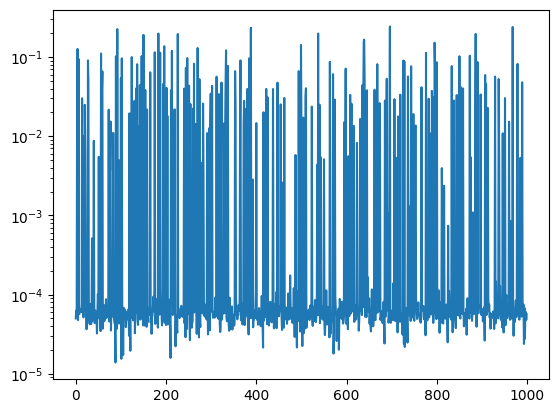

In [858]:
plt.semilogy(err_pos)
for dd in fail_range:
    print(dd[0]*rad2deg, dd[3]*rad2deg)
    print(dd[1],dd[2])
    print('##############')
model.lowerPositionLimit*rad2deg